 ## 1-Preprocessing for unsw-nb15 dataset

Load module

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, vstack
from scipy import sparse
import joblib
import os
from sklearn.decomposition import TruncatedSVD
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

Load dataset

In [4]:
# Load train/test từ file CSV
train_df = pd.read_csv("../dataset/unsw-nb15/UNSW_NB15_training-set.csv")
test_df = pd.read_csv("../dataset/unsw-nb15/UNSW_NB15_testing-set.csv")

# Gộp dữ liệu
full_df = pd.concat([train_df, test_df], ignore_index=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (175341, 45)
Test shape: (82332, 45)


Null value handling

In [5]:
full_df = full_df.dropna()
train_df = train_df.dropna()
test_df = test_df.dropna()

print("Full shape:", full_df.shape)
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

label_counts = train_df['label'].value_counts()
print("Tỷ lệ Benign (0) và Malicious (1):")
print(label_counts)

print("\nCác loại attack trong 'attack_cat':")
print(train_df['attack_cat'].value_counts())

Full shape: (257673, 45)
Train shape: (175341, 45)
Test shape: (82332, 45)
Tỷ lệ Benign (0) và Malicious (1):
label
1    119341
0     56000
Name: count, dtype: int64

Các loại attack trong 'attack_cat':
attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64


Tách X/y

In [6]:
# Xử lý training set
X_train = train_df.drop(columns=["id", "attack_cat", "label"])
y_train = (train_df["label"] != 0).astype(int)

# Xử lý test set
X_test = test_df.drop(columns=["id", "attack_cat", "label"])
y_test = (test_df["label"] != 0).astype(int)

print("Training X shape:", X_train.shape)
print("Training y distribution:", np.bincount(y_train))

Training X shape: (175341, 42)
Training y distribution: [ 56000 119341]


Min-max normalization

In [7]:
# One-hot encoding cho cột dạng chuỗi (object)
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Căn chỉnh cột giữa train và test
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Chuẩn hóa
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Kiểm tra
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (175341, 194)
X_test_scaled shape: (82332, 194)


## 2-ASmoT oversampling

Load ASmoT OverSampling

In [8]:

def asmot_extended(
    X_sparse        : csr_matrix,
    y,
    minority_class  : int = 0,
    target_total    : int = None,   # Số lượng tổng mong muốn cho lớp thiểu số
    k_neighbors     : int = 5,
    k_step          : int = 5,      # mỗi vòng tăng thêm bao nhiêu k
    max_per_sample  : int = 20,     # tối đa synthetic / seed
    max_loop        : int = 5       # tối đa số vòng tăng k
):
    """
    ASmoT cải tiến sinh đủ mẫu synthetic cho lớp thiểu số
    ----------------------------------------------------
    Parameters
    ----------
    X_sparse : csr_matrix  -- ma trận đặc trưng (sparse)
    y        : array-like   -- nhãn
    minority_class : int    -- giá trị lớp thiểu số cần oversample
    target_total   : int    -- tổng bản ghi mong muốn của minority (train)
    k_neighbors    : int    -- số hàng xóm khởi tạo
    k_step, max_loop, max_per_sample : tham số điều khiển vòng lặp

    Returns
    -------
    X_new : csr_matrix  -- ma trận sau oversample
    y_new : ndarray     -- nhãn sau oversample
    """
    assert isinstance(X_sparse, csr_matrix), "X phải ở dạng csr_matrix"
    y = np.array(y).ravel()

    # ----------------- Thống kê ban đầu -----------------
    X_min = X_sparse[y == minority_class]
    n_min = X_min.shape[0]
    if target_total is None or target_total <= n_min:
        print("[ASmoT] Không cần oversample.")
        return X_sparse, y

    needed_total   = target_total - n_min
    print(f"[ASmoT] Cần sinh thêm {needed_total:,} mẫu cho lớp {minority_class}")

    # ----------------------------------------------------
    loop, generated = 0, 0
    X_syn_list = []

    while generated < needed_total and loop < max_loop:
        k_now = k_neighbors + loop * k_step
        print(f"\n[ASmoT] --- Vòng {loop+1} | k_neighbors = {k_now} ---")

        # Fit nearest‑neighbors
        nn = NearestNeighbors(n_neighbors=k_now+1,
                              metric='cosine', algorithm='brute', n_jobs=-1)
        nn.fit(X_sparse)
        _, indices = nn.kneighbors(X_min)

        # Phân loại IPR / DPR
        ipr_idx, dpr_idx = [], []
        for i, idxs in enumerate(indices):
            neigh_labels = y[idxs[1:]]
            n_same  = np.sum(neigh_labels == minority_class)
            n_other = k_now - n_same
            if n_same == 0:              # IPR
                ipr_idx.append(i)
            elif n_other > n_same:       # DPR
                dpr_idx.append(i)

        seed_idx = ipr_idx + dpr_idx
        if not seed_idx:
            print("[ASmoT]  Không tìm thấy seed. Tăng k.")
            loop += 1
            continue

        # Xác định số synthetic mỗi seed
        remain_need      = needed_total - generated
        per_seed_default = max(1, remain_need // len(seed_idx))
        per_seed         = min(per_seed_default, max_per_sample)

        print(f"[ASmoT]  IPR: {len(ipr_idx)}, DPR: {len(dpr_idx)} "
              f"| Sẽ sinh {per_seed} mẫu/seed (tối đa {max_per_sample})")

        # --------- Sinh synthetic ----------
        for i in seed_idx:
            xi = X_min.getrow(i)
            neigh_idx   = indices[i][1:]

            if i in ipr_idx:
                cand = [idx for idx in neigh_idx if y[idx] != minority_class]
                if not cand:
                    continue
                for _ in range(per_seed):
                    xj = X_sparse.getrow(np.random.choice(cand))
                    alpha = np.random.rand()
                    X_syn_list.append(xi + (xj - xi).multiply(alpha))

            else:  # DPR
                neighs = [X_sparse.getrow(j) for j in neigh_idx
                          if y[j] != minority_class]
                if not neighs:
                    continue
                ym = sum(neighs) / len(neighs)
                for _ in range(per_seed):
                    alpha = np.random.rand()
                    X_syn_list.append(xi + (ym - xi).multiply(alpha))

            generated += per_seed
            if generated >= needed_total:
                break

        print(f"[ASmoT]  Đã sinh {generated:,}/{needed_total:,} mẫu")
        loop += 1

    # -------------- Ghép & trả về ----------------
    if not X_syn_list:
        print("[ASmoT]  Không sinh được synthetic sample nào.")
        return X_sparse, y

    X_syn = vstack(X_syn_list)
    y_syn = np.full(X_syn.shape[0], minority_class)
    X_new = vstack([X_sparse, X_syn])
    y_new = np.concatenate([y, y_syn])

    print(f"[ASmoT] ✔️  Tổng cuối cùng lớp {minority_class}: "
          f"{np.sum(y_new==minority_class):,}")

    return X_new, y_new


Oversampling by ASmoT

In [9]:
# Chuyển X_train thành dạng sparce
X_train_sparse = csr_matrix(X_train_scaled)

# Giả sử đã có X_train_sparse (csr_matrix) và y_train
TARGET_BENIGN_TRAIN = 99905   # 56 000 gốc + 43 905 cần sinh

X_train_res, y_train_res = asmot_extended(
    X_train_sparse,
    y_train,
    minority_class=0,
    target_total=TARGET_BENIGN_TRAIN,
    k_neighbors=8,      # bắt đầu thấp
    k_step=4,           # mỗi vòng tăng thêm 4
    max_per_sample=15,  # tối đa 15 synthetic/seed
    max_loop=6          # thử tối đa 6 vòng
)

print("After ASmoT oversampling:")
print("    Resampled X shape:", X_train_res.shape)
print("    Resampled y distribution:", np.bincount(y_train_res))

[ASmoT] Cần sinh thêm 43,905 mẫu cho lớp 0

[ASmoT] --- Vòng 1 | k_neighbors = 8 ---
[ASmoT]  IPR: 585, DPR: 4937 | Sẽ sinh 7 mẫu/seed (tối đa 15)
[ASmoT]  Đã sinh 38,654/43,905 mẫu

[ASmoT] --- Vòng 2 | k_neighbors = 12 ---
[ASmoT]  IPR: 343, DPR: 5769 | Sẽ sinh 1 mẫu/seed (tối đa 15)
[ASmoT]  Đã sinh 43,905/43,905 mẫu
[ASmoT] ✔️  Tổng cuối cùng lớp 0: 99,905
After ASmoT oversampling:
    Resampled X shape: (219246, 194)
    Resampled y distribution: [ 99905 119341]


Save variables after oversampling

In [10]:
save_dir = "../preprocessed"
os.makedirs(save_dir, exist_ok=True)

# Lưu train (sparse)
sparse.save_npz(os.path.join(save_dir, "X_train_res.npz"), X_train_res)
joblib.dump(y_train_res, os.path.join(save_dir, "y_train_res.pkl"))

# Lưu test (dense)
np.savez(os.path.join(save_dir, "X_test_scaled.npz"), X=X_test_scaled)
np.save(os.path.join(save_dir, "y_test.npy"), y_test)

## 3-Feature extraction(M‑SvD)

Nếu đã chạy xong phần 1,2 rồi thì bắt đầu chạy từ đây

Load variables oversampling

In [11]:
SAVE_DIR = "../preprocessed"

# --- TRAIN ---
#  > X_train_res.npz
#  > y_train_res.pkl
X_train_sparse = sparse.load_npz(os.path.join(SAVE_DIR, "X_train_res.npz"))
y_train = joblib.load(os.path.join(SAVE_DIR, "y_train_res.pkl"))

# --- TEST ---
# > X_test_scaled.npz
# > y_test.npy
X_test_scaled = np.load(os.path.join(SAVE_DIR, "X_test_scaled.npz"))["X"]
y_test = np.load(os.path.join(SAVE_DIR, "y_test.npy"))

print("Train  X:", X_train_sparse.shape,
      "| y:", y_train.shape)
print("Test   X:", X_test_scaled.shape,
      "| y:", y_test.shape)


Train  X: (219246, 194) | y: (219246,)
Test   X: (82332, 194) | y: (82332,)


M-SvD function

In [12]:
def select_g_star_SEK(X_proj, sigma, components, min_g=5, max_g=50):
    sek_vals = []
    ek_vals  = []
    for g in range(1, components):
        Ug = X_proj[:, :g]
        Sg = np.diag(sigma[:g])
        Vg = svd_probe.components_[:g, :]
        Xg = Ug @ Sg @ Vg
        ek = kurtosis(np.abs(Xg).ravel(), fisher=False)
        ek_vals.append(ek)
    ek_vals = np.array(ek_vals)
    sek = np.abs(np.diff(ek_vals) / ek_vals[1:])

    # Chỉ tìm g* trong khoảng min_g..max_g
    g_range = np.arange(1, len(sek) + 1)  # vì diff giảm đi 1
    valid_mask = (g_range >= min_g) & (g_range <= max_g)
    g_star = g_range[valid_mask][np.argmax(sek[valid_mask])]

    return g_star

def msvd_extract(
    X_train,
    X_test,
    y_train=None,
    y_test=None,
    probe_components=100,
    fixed_g=None,
    use_energy=False,
    energy_thr=0.9,
    min_g=5,
    max_g=50,
    save_path=None,
    random_state=42
):
    # ---------- Bước 1: SVD "thăm dò" ----------
    svd_probe = TruncatedSVD(
        n_components=min(probe_components, X_train.shape[1] - 1),
        algorithm="randomized",
        random_state=random_state
    )
    X_proj = svd_probe.fit_transform(X_train)
    sigma = svd_probe.singular_values_
    components = svd_probe.components_

    # ---------- Bước 2: Chọn g★ ----------
    if fixed_g is not None:
        g_star = fixed_g
    elif use_energy:
        cum_energy = np.cumsum(sigma ** 2) / np.sum(sigma ** 2)
        g_star = np.searchsorted(cum_energy, energy_thr) + 1
    else:
        ek = []
        for g in range(1, len(sigma)):
            Ug = X_proj[:, :g]
            Sg = np.diag(sigma[:g])
            Vg = components[:g, :]
            Xg = Ug @ Sg @ Vg
            ek_val = kurtosis(np.abs(Xg).ravel(), fisher=False)
            ek.append(ek_val)
        ek = np.array(ek)
        sek = np.abs(np.diff(ek) / ek[1:])

        g_range = np.arange(1, len(sek) + 1)
        valid_mask = (g_range >= min_g) & (g_range <= max_g)
        if not np.any(valid_mask):
            raise ValueError("Không có g nào thỏa điều kiện min_g/max_g")
        g_star = g_range[valid_mask][np.argmax(sek[valid_mask])]

    print(f"[M-SvD] Selected g★ = {g_star}")

    # ---------- Bước 3: SVD cuối cùng ----------
    svd_final = TruncatedSVD(
        n_components=g_star,
        algorithm="randomized",
        random_state=random_state
    )
    X_train_msvd = svd_final.fit_transform(X_train)
    X_test_msvd = svd_final.transform(X_test)

    print(f"[M-SvD] Train shape: {X_train_msvd.shape} | Test shape: {X_test_msvd.shape}")

    # ---------- Bước 4: Lưu nếu cần ----------
    if save_path:
        obj = dict(
            X_train_msvd=X_train_msvd,
            X_test_msvd=X_test_msvd,
            g_star=g_star,
            svd_model=svd_final
        )
        if y_train is not None:
            obj["y_train"] = y_train
        if y_test is not None:
            obj["y_test"] = y_test
        joblib.dump(obj, save_path)
        print(f"[M-SvD] Saved to {save_path}")

    return X_train_msvd, X_test_msvd, g_star, svd_final

Feature extraction by M-SvD

In [13]:
X_train_msvd, X_test_msvd, g_star, svd_model = msvd_extract(
    X_train_sparse,
    sparse.csr_matrix(X_test_scaled),
    y_train=y_train,
    y_test=y_test,
    probe_components=150,
    use_energy=False,          # dùng SEK
    min_g=5,
    max_g=60,
    save_path="../preprocessed/msvd_features.pkl"
)

[M-SvD] Selected g★ = 9
[M-SvD] Train shape: (219246, 9) | Test shape: (82332, 9)
[M-SvD] Saved to ../preprocessed/msvd_features.pkl


## 4- Feature selection

Nếu đã chạy bước phần 3 rồi thì bắt đầu từ đây

Load ongo_feature_select function

In [14]:
def ongoing_fitness(mask, X, y, val_size=0.15, alpha=0.99, beta=0.01, rs=42):
    if mask.sum() == 0:
        return 1.0
    X_sel = X[:, mask==1]
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_sel, y, test_size=val_size, random_state=rs, stratify=y)

    clf = RandomForestClassifier(
            n_estimators=120, max_depth=None,
            n_jobs=-1, random_state=rs)
    clf.fit(X_tr, y_tr)
    acc = accuracy_score(y_va, clf.predict(X_va))
    d = X.shape[1]
    return alpha*(1-acc) + beta*(mask.sum()/d)


def ongo_feature_select(
    X, y,
    pop_size      = 20,     # số goshawk
    max_iter      = 40,
    alpha_fitness = 0.9,
    beta_fitness  = 0.1,
    opposition    = True,
    random_state  = 42,
    save_path     = None
):
    """
    Implementation của Opposition‑based Northern Goshawk Optimization
    để chọn feature‑subset nhị phân.
    Trả về:
        best_mask   – ndarray bool (d,)
        history     – list(best_fitness từng vòng)
    """
    rng = np.random.default_rng(random_state)
    n_samples, d = X.shape

    # ----- Khởi tạo quần thể --------------------------
    pop = rng.integers(0, 2, size=(pop_size, d), dtype=np.int8)
    fitness = np.array([ongoing_fitness(m, X, y, alpha=alpha_fitness,
                                        beta=beta_fitness, rs=random_state)
                        for m in pop])
    best_idx  = np.argmin(fitness)
    best_mask = pop[best_idx].copy()
    best_fit  = fitness[best_idx]
    history   = [best_fit]

    # --------------------------------------------------
    for t in range(1, max_iter + 1):
        w = rng.random()              # tham số ngẫu nhiên (paper dùng w∈[0,1])
        L = 0.02 * (1 - t / max_iter)

        for i in range(pop_size):
            mask_i = pop[i].copy()

            # ----- Prey identification & attack (nhị phân) -----
            # Chọn ngẫu nhiên 1 goshawk khác f (prey)
            j = rng.choice([x for x in range(pop_size) if x != i])
            f = pop[j]

            rand_flip = rng.random(d) < 0.1          # tần suất đổi bit
            new_mask  = mask_i.copy()
            # áp công thức “g + w*(f - g)”  → với nhị phân: copy bit từ f
            new_mask[rand_flip] = f[rand_flip]

            # ----- Chase & escape (nhị phân) -------------
            if rng.random() < 0.5:
                rand_flip2 = rng.random(d) < L        # L giảm dần
                new_mask[rand_flip2] ^= 1             # lật bit

            # ----- Đảm bảo không mask rỗng ---------------
            if new_mask.sum() == 0:
                new_mask[rng.integers(0, d)] = 1

            # ----- opposition‑based learning -------------
            if opposition:
                opp_mask = 1 - new_mask
                f1 = ongoing_fitness(new_mask, X, y,
                                     alpha=alpha_fitness, beta=beta_fitness)
                f2 = ongoing_fitness(opp_mask, X, y,
                                     alpha=alpha_fitness, beta=beta_fitness)
                if f2 < f1:
                    new_mask, f1 = opp_mask, f2
            else:
                f1 = ongoing_fitness(new_mask, X, y,
                                     alpha=alpha_fitness, beta=beta_fitness)

            # ----- Chấp nhận nếu tốt hơn cá thể i ---------
            if f1 < fitness[i]:
                pop[i]   = new_mask
                fitness[i] = f1

                # cập nhật best toàn cục
                if f1 < best_fit:
                    best_fit  = f1
                    best_mask = new_mask.copy()

        history.append(best_fit)
        print(f"[ONgO] iter {t}/{max_iter}  best_fitness={best_fit:.4f}  "
              f"feat={best_mask.sum()}")

    if save_path:
        joblib.dump(dict(best_mask=best_mask, history=history),
                    save_path)
        print(f"[ONgO] Saved mask to {save_path}")

    return best_mask, history


Load features msvd

In [15]:
# nạp đặc trưng từ bước M‑SvD
data = joblib.load("../preprocessed/msvd_features.pkl")
X_train_msvd = data["X_train_msvd"]
y_train      = data["y_train"]
X_test_msvd  = data["X_test_msvd"]
y_test       = data["y_test"]

Feature selection by ONgO

In [16]:
# ---- chạy ONgO ----
best_mask, hist = ongo_feature_select(
    X_train_msvd, y_train,
    pop_size   = 25,
    max_iter   = 10,
    alpha_fitness = 0.9,
    beta_fitness  = 0.1,
    opposition = True,
    random_state = 42,
    save_path = "../preprocessed/ongo_mask.pkl"
)

print("Số feature được chọn:", best_mask.sum())


[ONgO] iter 1/10  best_fitness=0.1081  feat=3
[ONgO] iter 2/10  best_fitness=0.1080  feat=3
[ONgO] iter 3/10  best_fitness=0.1080  feat=3
[ONgO] iter 4/10  best_fitness=0.1076  feat=3
[ONgO] iter 5/10  best_fitness=0.1076  feat=3
[ONgO] iter 6/10  best_fitness=0.1076  feat=3
[ONgO] iter 7/10  best_fitness=0.1076  feat=3
[ONgO] iter 8/10  best_fitness=0.1076  feat=3
[ONgO] iter 9/10  best_fitness=0.1076  feat=3
[ONgO] iter 10/10  best_fitness=0.1076  feat=3
[ONgO] Saved mask to ../preprocessed/ongo_mask.pkl
Số feature được chọn: 3


## 5- M‑MultiSVM

Nạp đặc trưng từ bước ONgO

In [17]:
data = joblib.load("../preprocessed/msvd_features.pkl")
mask = joblib.load("../preprocessed/ongo_mask.pkl")["best_mask"]

X_train_sel = data["X_train_msvd"][:, mask == 1]
X_test_sel  = data["X_test_msvd"][:, mask == 1]
y_train     = data["y_train"]
y_test      = data["y_test"]

print("X_train_sel shape:", X_train_sel.shape)
print("X_test_sel shape :", X_test_sel.shape)

X_train_sel shape: (219246, 3)
X_test_sel shape : (82332, 3)


Load M-MultiSVM function

In [18]:
# --- M-MultiSVM with Mud Ring Optimizer ---
# According to paper structure: MLP (as feature extractor) + SVM + Mud Ring optimization

def mud_ring_optimizer(X_train, y_train, X_val, y_val, pop_size=3, max_iter=3, random_state=42):
    np.random.seed(random_state)
    best_score = 0
    best_params = None

    pop = [
        {
            "C": 10 ** np.random.uniform(-1, 2),
            "gamma": 10 ** np.random.uniform(-4, -1),
            "hidden": np.random.randint(8, 32)  # 8–32 neurons
        }
        for _ in range(pop_size)
    ]

    for gen in range(max_iter):
        print(f"[MudRing] Generation {gen+1}/{max_iter}")
        for ind in pop:
            mlp = MLPClassifier(hidden_layer_sizes=(ind["hidden"],), max_iter=50,
                                early_stopping=True, n_iter_no_change=3, random_state=42)
            mlp.fit(X_train, y_train)
            X_tr_embed = mlp.predict_proba(X_train)
            X_val_embed = mlp.predict_proba(X_val)

            clf = SVC(C=ind["C"], gamma=ind["gamma"], kernel='rbf', probability=True)
            clf.fit(X_tr_embed, y_train)
            pred = clf.predict(X_val_embed)
            acc = accuracy_score(y_val, pred)

            if acc > best_score:
                best_score = acc
                best_params = ind.copy()

        for i in range(pop_size):
            pop[i] = {
                "C": best_params["C"] * 10 ** np.random.uniform(-0.2, 0.2),
                "gamma": best_params["gamma"] * 10 ** np.random.uniform(-0.2, 0.2),
                "hidden": max(8, min(32,
                             best_params["hidden"] + np.random.randint(-4, 4)))
            }

    print("[MudRing] Best accuracy:", best_score)
    print("[MudRing] Best parameters:", best_params)
    return best_params


def train_m_multisvm(X_train, y_train, X_test, y_test):
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

    best = mud_ring_optimizer(X_tr, y_tr, X_val, y_val, pop_size=3, max_iter=3)

    mlp = MLPClassifier(
        hidden_layer_sizes=(best["hidden"],),
        max_iter=50,
        early_stopping=True,
        n_iter_no_change=3,
        tol=1e-4,
        random_state=42
    )

    mlp.fit(X_train, y_train)
    X_train_embed = mlp.predict_proba(X_train)
    X_test_embed = mlp.predict_proba(X_test)

    clf = SVC(C=best["C"], gamma=best["gamma"], kernel='rbf', probability=True)
    clf.fit(X_train_embed, y_train)
    y_pred = clf.predict(X_test_embed)
    y_score = clf.predict_proba(X_test_embed)[:, 1] if len(np.unique(y_test)) == 2 else None

    # Save model
    os.makedirs("../models", exist_ok=True)
    joblib.dump(clf, "../models/multisvm_svm.pkl")
    joblib.dump(mlp, "../models/multisvm_mlp.pkl")
    joblib.dump(best, "../models/multisvm_best_params.pkl")
    print("✅ Đã lưu mô hình M-MultiSVM vào thư mục models/")

    return clf, mlp, best, y_pred, y_score


def evaluate_m_multisvm(y_test, y_pred, y_score):
    print("\n[M-MultiSVM Evaluation]")
    print(classification_report(y_test, y_pred, digits=4))
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
    print("F1-score :", f1_score(y_test, y_pred, average='weighted'))
    if y_score is not None:
        print("AUC      :", roc_auc_score(y_test, y_score))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

Train M-MultiSVM

[MudRing] Generation 1/3
[MudRing] Generation 2/3
[MudRing] Generation 3/3
[MudRing] Best accuracy: 0.806932725199544
[MudRing] Best parameters: {'C': 1.3292918943162162, 'gamma': 0.07114476009343416, 'hidden': 18}
✅ Đã lưu mô hình M-MultiSVM vào thư mục models/

[M-MultiSVM Evaluation]
              precision    recall  f1-score   support

           0     0.7317    0.9317    0.8197     37000
           1     0.9283    0.7211    0.8117     45332

    accuracy                         0.8158     82332
   macro avg     0.8300    0.8264    0.8157     82332
weighted avg     0.8399    0.8158    0.8153     82332

Accuracy : 0.8157824418209202
Precision: 0.8399328142915551
Recall   : 0.8157824418209202
F1-score : 0.8152920822579568
AUC      : 0.907087357299062


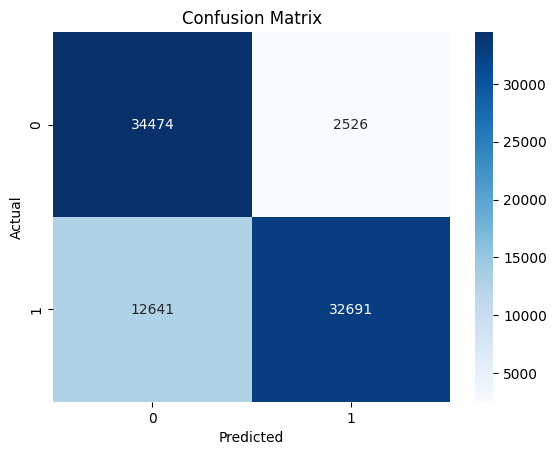

In [19]:
clf, mlp, best, y_pred, y_score = train_m_multisvm(X_train_sel, y_train, X_test_sel, y_test)

evaluate_m_multisvm(y_test, y_pred, y_score)

# So sánh baseline models trên feature sau khi chay ONgO

Training & evaluating LR...
Training & evaluating DT...
Training & evaluating RF...
Training & evaluating KNN...
Training & evaluating AdaBoost...
Training & evaluating XGBoost...


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:02:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training & evaluating LightGBM...
[LightGBM] [Info] Number of positive: 119341, number of negative: 99905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 219246, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544325 -> initscore=0.177765
[LightGBM] [Info] Start training from score 0.177765


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Accuracy (%),Precision (%),Recall (%),F1-score (%),False Positive Rate (%)
Model,,,,,
LR,76.892338,77.547818,76.892338,76.412874,36.759459
DT,85.045912,85.129269,85.045912,84.967639,20.767568
RF,87.149589,87.152343,87.149589,87.120744,16.354054
KNN,86.090463,86.087527,86.090463,86.088891,15.597297
AdaBoost,80.735316,80.775982,80.735316,80.750172,20.518919
XGBoost,89.320070,90.080452,89.320070,89.345816,4.875676
LightGBM,88.582811,89.870278,88.582811,88.599348,3.362162
Proposed,88.582811,89.870278,88.582811,88.599348,3.362162


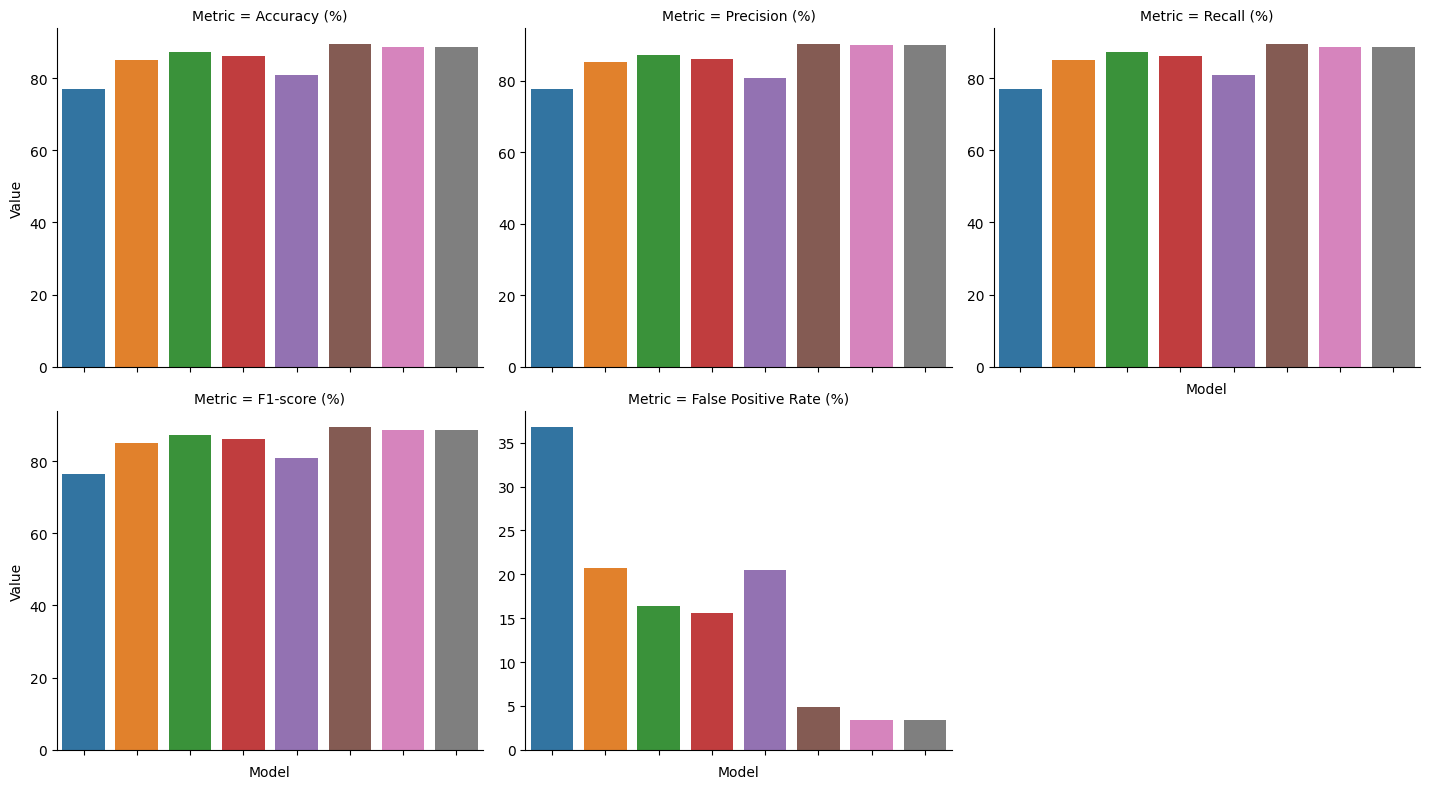

In [27]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics       import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model  import LogisticRegression
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors     import KNeighborsClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier

# 1) Định nghĩa các model baseline
models = {
    "LR"       : LogisticRegression(max_iter=200, random_state=42),
    "DT"       : DecisionTreeClassifier(random_state=42),
    "RF"       : RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN"      : KNeighborsClassifier(n_neighbors=5),
    "AdaBoost" : AdaBoostClassifier(n_estimators=50, random_state=42),
    "XGBoost"  : XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM" : LGBMClassifier(random_state=42)
}

# 2) Train & thu thập metric
records = []
for name, mdl in models.items():
    print(f"Training & evaluating {name}...")
    t0 = time.time()
    mdl.fit(X_train_sel, y_train)
    train_time = time.time() - t0
    
    y_pred = mdl.predict(X_test_sel)
    acc   = accuracy_score(y_test, y_pred) * 100
    prec  = precision_score(y_test, y_pred, average='weighted') * 100
    rec   = recall_score(y_test, y_pred, average='weighted') * 100
    f1    = f1_score(y_test, y_pred, average='weighted') * 100
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr   = fp / (fp + tn) * 100
    
    records.append({
        "Model": name,
        "Accuracy (%)"         : acc,
        "Precision (%)"        : prec,
        "Recall (%)"           : rec,
        "F1-score (%)"         : f1,
        "False Positive Rate (%)": fpr,
    })

# 3) Thêm model Proposed (M-MultiSVM)
acc_prop = accuracy_score(y_test, y_pred)
prec_prop = precision_score(y_test, y_pred, average='weighted')
rec_prop  = recall_score(   y_test, y_pred, average='weighted')
f1_prop   = f1_score(      y_test, y_pred, average='weighted')
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr_prop = fp/(fp+tn)

records.append({
    "Model": "Proposed",
    "Accuracy (%)"         : acc_prop*100,
    "Precision (%)"        : prec_prop*100,
    "Recall (%)"           : rec_prop*100,
    "F1-score (%)"         : f1_prop*100,
    "False Positive Rate (%)": fpr_prop*100,
})

# 4) Tạo DataFrame
df_metrics = pd.DataFrame(records).set_index("Model")
display(df_metrics)

# 5) Vẽ biểu đồ cột cho mỗi metric
df_melt = df_metrics.reset_index().melt(id_vars="Model", var_name="Metric", value_name="Value")
g = sns.catplot(
    data=df_melt, x="Model", y="Value", hue="Model",
    col="Metric", col_wrap=3, kind="bar", sharey=False,
    height=4, aspect=1.2
)

g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()
